In [ ]:
import torch
import time
import warnings
import random
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from lion_pytorch import Lion 

from collections import defaultdict

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, add_self_loops, coalesce
from torch_geometric.nn import SAGEConv, GCNConv

from window_slider import Slider

from imblearn.over_sampling import SMOTE

In [ ]:
warnings.filterwarnings('ignore')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True  # Ensures same computations
torch.backends.cudnn.benchmark = False 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Load the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path, nrows = 1600000)
    df['attack_cat'] = df['attack_cat'].fillna('Benign')
    return df

def data_desc(data):
    print()
    print("DATA DESCRIPTION")
    print("Data size (Records, Features):", data.shape)
    
    feature_desc = pd.DataFrame(
                                (zip(data.columns, 
                                    [data[col].dtype for col in data.columns], 
                                    data.nunique(), 
                                    data.isna().sum()/data.shape[0] * 100)), 
                    columns=["Name", "Type", "Unique levels", "Missing Ratio %"])
    print("Features description:\n", feature_desc)
    
    print("Duplicate rows:", data.duplicated().sum())


def split_and_prepare_data(df, train_ratio=0.6, val_ratio=0.2):
    # Drop duplicates to avoid data leakage
    df = df.drop_duplicates()

    # Shuffle before splitting
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

 # Ensure at least one of each attack type in the dataset
    unique_attacks = df.groupby('attack_cat').apply(lambda x: x.sample(1, random_state=SEED)).reset_index(drop=True)
    remaining_df = df.drop(index=unique_attacks.index)

    # Shuffle remaining data
    remaining_df = remaining_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Combine guaranteed attack coverage with remaining
    combined_df = pd.concat([unique_attacks, remaining_df], ignore_index=True)

    # Now stratified split on combined_df
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_ratio, random_state=SEED)
    for train_idx, test_val_idx in strat_split.split(combined_df, combined_df['attack_cat']):
        train = combined_df.iloc[train_idx]
        test_val = combined_df.iloc[test_val_idx]

    # Split validation and test
    val_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - train_ratio), random_state=SEED)
    for val_idx, test_idx in val_split.split(test_val, test_val['attack_cat']):
        validation = test_val.iloc[val_idx]
        test = test_val.iloc[test_idx]

    # Sanity check: make sure every attack appears in the train set
    missing_attacks = set(df['attack_cat'].unique()) - set(train['attack_cat'].unique())
    if missing_attacks:
        print(f"Warning: The following attack types are missing from the training set: {missing_attacks}")

    # Print dataset sizes and attack distribution
    print(f"Training set: {train.shape[0]} samples")
    print(train['attack_cat'].value_counts(), "\n")

    print(f"Validation set: {validation.shape[0]} samples")
    print(validation['attack_cat'].value_counts(), "\n")

    print(f"Test set: {test.shape[0]} samples")
    print(test['attack_cat'].value_counts(), "\n")

    # Separate features and labels
    train_target = train["Label"]
    validation_target = validation["Label"]
    test_target = test["Label"]

    # Drop unnecessary columns
    drop_cols = ["Label", "attack_cat"]
    train_features = train.drop(columns=drop_cols)
    validation_features = validation.drop(columns=drop_cols)
    test_features = test.drop(columns=drop_cols)

    return train_features, train_target, validation_features, validation_target, test_features, test_target


def data_preprocessing(features, scaler=None, encoder=None):
    # Replace inf/-inf with NaN and drop rows
    features = features.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Extract and encode nodes
    snode = features['srcip'].astype(str) + '-' + features['sport'].astype(str)
    dnode = features['dstip'].astype(str) + '-' + features['dsport'].astype(str)
    
    # Drop original columns
    features = features.drop(columns=['srcip', 'sport', 'dstip', 'dsport'])

    # Separate categorical and numerical features
    categorical_cols = features.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = features.select_dtypes(include=['number']).columns.tolist()

    features[categorical_cols] = features[categorical_cols].astype(str)
    
    # === Critical Step: Encode Categoricals In-Place ===
    if categorical_cols:
        features[categorical_cols] = features[categorical_cols].astype(str)
        if encoder is None:
            encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            features[categorical_cols] = encoder.fit_transform(features[categorical_cols])
        else:
            features[categorical_cols] = encoder.transform(features[categorical_cols])
    else:
        encoder = None 
    
    # Scale numerical features
    if scaler is None:
        scaler = MinMaxScaler()
        features[numerical_cols] = scaler.fit_transform(features[numerical_cols])
    else:
        features[numerical_cols] = scaler.transform(features[numerical_cols])
    
    return features, snode, dnode, encoder, scaler

        srcip  sport          dstip dsport proto state       dur  sbytes  \
0  59.166.0.0   1390  149.171.126.6     53   udp   CON  0.001055     132   
1  59.166.0.0  33661  149.171.126.9   1024   udp   CON  0.036133     528   
2  59.166.0.6   1464  149.171.126.7     53   udp   CON  0.001119     146   
3  59.166.0.5   3593  149.171.126.5     53   udp   CON  0.001209     132   

   dbytes  sttl  ...  ct_ftp_cmd  ct_srv_src  ct_srv_dst ct_dst_ltm  \
0     164    31  ...           0           3           7          1   
1     304    31  ...           0           2           4          2   
2     178    31  ...           0          12           8          1   
3     164    31  ...           0           6           9          1   

   ct_src_ltm  ct_src_dport_ltm  ct_dst_sport_ltm  ct_dst_src_ltm  attack_cat  \
0           3                 1                 1               1      Benign   
1           3                 1                 1               2      Benign   
2           2       

<Axes: >

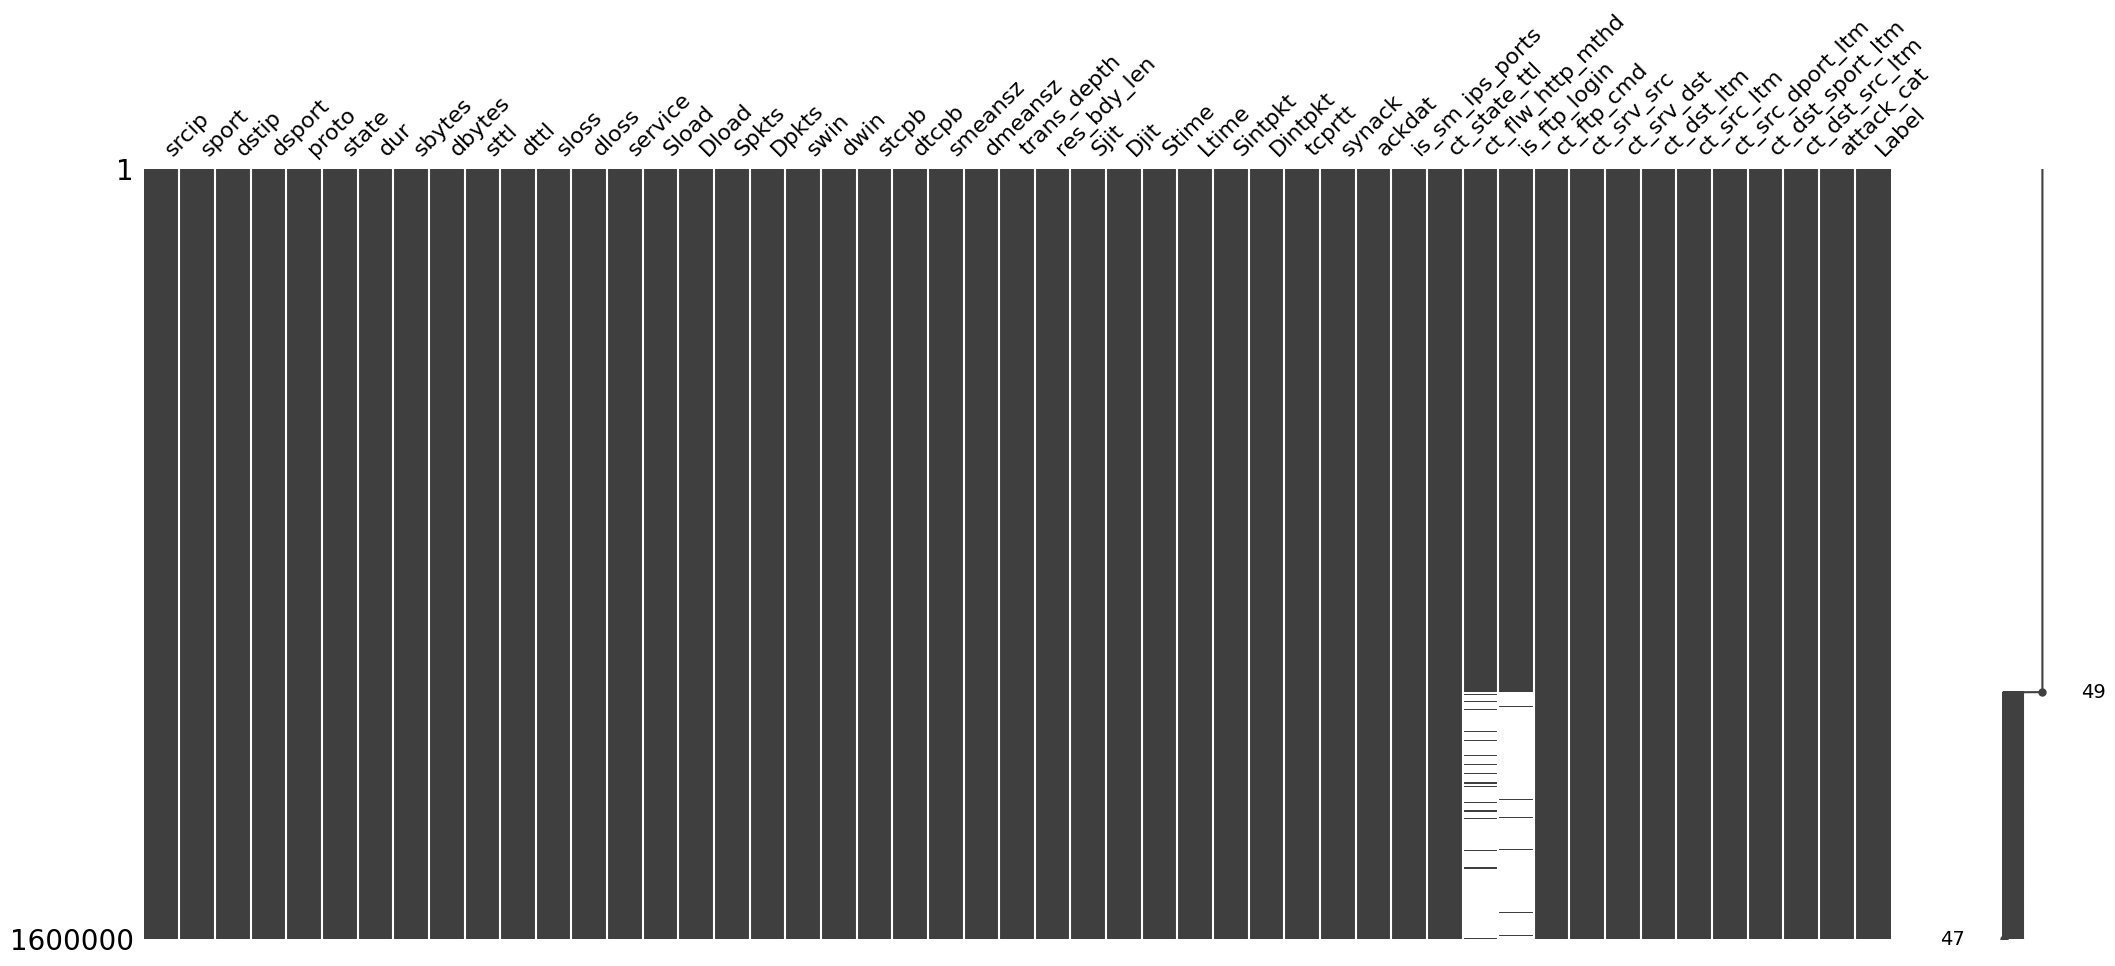

In [ ]:
# Prepare the device (Check for cuda availability)
path = 'D:/TA2/Dataset'
# Load the dataset
df = load_dataset(path + "/UNSW-NB15.csv")

# # Check the integrity of the dataset
print(df.head(4))
data_desc(df)
msno.matrix(df)

In [ ]:
# Split the dataset
train_features, train_target, validation_features, validation_target, test_features, test_target = split_and_prepare_data(df)

# Preprocess the dataset
train_features, train_snode, train_dnode, encoder, scaler = data_preprocessing(train_features)
validation_features, validation_snode, validation_dnode, _, _ = data_preprocessing(validation_features, scaler, encoder)
test_features, test_snode, test_dnode, _, _  = data_preprocessing(test_features, scaler, encoder)


input_dim = train_features.shape[1]
print("Input dimension:", input_dim)

# Check the processed data
print("Processed Features:")
print(train_features.head())
print("\nSource Nodes:")
print(train_snode[:10])
print("\nDestination Nodes:")
print(train_dnode[:10])
print("length")
print(train_features.shape)

Training set: 845262 samples
attack_cat
Benign              818008
Exploits              7796
Generic               6312
 Fuzzers              4043
 Reconnaissance       2628
 Fuzzers              2395
DoS                   1566
Reconnaissance        1045
Analysis               558
 Shellcode             296
Backdoor               251
Backdoors              181
Shellcode              134
Worms                   49
Name: count, dtype: int64 

Validation set: 281754 samples
attack_cat
Benign              272669
Exploits              2599
Generic               2105
 Fuzzers              1348
 Reconnaissance        877
 Fuzzers               798
DoS                    522
Reconnaissance         348
Analysis               186
 Shellcode              98
Backdoor                83
Backdoors               60
Shellcode               45
Worms                   16
Name: count, dtype: int64 

Test set: 281754 samples
attack_cat
Benign              272670
Exploits              2599
Generic         

  File "d:\TA2\TA_SVer\Top 3 ver\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Generated 790754 synthetic samples

After SMOTE:
Training features shape: (1636016, 43)
Class distribution: 0    818008
1    818008
Name: count, dtype: int64
Processed Features:
   proto  state       dur    sbytes    dbytes      sttl      dttl     sloss  \
0  120.0    2.0  0.000064  0.000040  0.000021  0.121569  0.114173  0.000000   
1  114.0    5.0  0.000009  0.000273  0.003922  0.121569  0.114173  0.001316   
2  114.0    5.0  0.000026  0.002607  0.000231  0.121569  0.114173  0.003384   
3  114.0    5.0  0.000026  0.000030  0.000602  0.121569  0.114173  0.000188   
4  114.0    5.0  0.000008  0.000360  0.006220  0.121569  0.114173  0.001316   

      dloss  service  ...  ct_flw_http_mthd  is_ftp_login  ct_ftp_cmd  \
0  0.000000      0.0  ...               0.0           0.0         1.0   
1  0.004923      0.0  ...               0.0           0.0         1.0   
2  0.001459      9.0  ...               0.0           0.0         0.0   
3  0.000729      0.0  ...               0.0           0

In [ ]:
def graph(features, snode, dnode, target, kernel_size=50, train_ratio=0.5, is_train = False):
    
    num_flows = len(features)
    
    # === Structural Edges (Shared Endpoints) ===
    endpoint_groups = defaultdict(list)
    for idx, (s, d) in enumerate(zip(snode, dnode)):
        endpoint_groups[s].append(idx)  # Group by source
        endpoint_groups[d].append(idx)  # Group by destination

    # Generate edges for flows sharing endpoints
    struct_edges = []
    for group in endpoint_groups.values():
        if len(group) > 1:
            pairs = torch.combinations(torch.tensor(group), r=2)
            struct_edges.append(pairs)
    
    struct_edge_index = torch.cat(struct_edges, dim=0).t() if struct_edges else torch.empty((2, 0), dtype=torch.long)
    struct_edge_index = to_undirected(struct_edge_index)
    struct_edge_index = coalesce(struct_edge_index, num_nodes=num_flows)  # Remove duplicates
    struct_edge_index, _ = add_self_loops(struct_edge_index, num_nodes=num_flows)  # Add self-loops

    # === Temporal Edges (Past-Only Connections) ===
    nodes = torch.arange(num_flows)
    offsets = -torch.arange(1, kernel_size + 1)  # Only look backward
    
    # Vectorized implementation for efficiency
    src = nodes.unsqueeze(1) + torch.zeros_like(offsets)
    dst = nodes.unsqueeze(1) + offsets
    mask = (dst >= 0)  # Filter invalid indices
    
    temp_edge_index = torch.stack([
        src[mask].flatten(),
        dst[mask].flatten()
    ])

    if is_train:
        # Mask labels for semi-supervised training (e.g., 50% labeled)
        num_labels = int(num_flows * train_ratio)
        label_mask = torch.zeros(num_flows, dtype=torch.bool)
        label_indices = torch.randperm(num_flows)[:num_labels]  # Random selection
        label_mask[label_indices] = True
    else:
        # Validation/test: Use all labels for evaluation
        label_mask = torch.ones(num_flows, dtype=torch.bool)

    return Data(
        x=torch.tensor(features.values, dtype=torch.float),
        y=torch.tensor(target.values.ravel(), dtype=torch.long),  # Ensure y is 1D
        struct_edge_index=struct_edge_index,
        temp_edge_index=temp_edge_index,
        label_mask=label_mask
    )


In [ ]:
def snapshots(features, snode, dnode, target, kernel_size, buffer_size, overlap_count, is_train = False):

    snapshots = []
    idx = np.arange(features.shape[0])
    slider = Slider(buffer_size, overlap_count)
    slider.fit(idx)     

    while True:
        window_data = slider.slide()

        idx_start = window_data[0]
        idx_end = window_data[-1]+1
        snapshot = graph(features=features[idx_start:idx_end], snode=snode[idx_start:idx_end], dnode=dnode[idx_start:idx_end], 
                       target=target[idx_start:idx_end], kernel_size=kernel_size, is_train = is_train)
        snapshots.append(snapshot)

        if slider.reached_end_of_list(): break

    return snapshots

In [ ]:
%%time

# Training Snapshot
train_snapshots = snapshots(features=train_features, snode=train_snode, dnode=train_dnode, target=train_target, 
             kernel_size=50, buffer_size=512, overlap_count=256, is_train = True)

print("Training Snapshot")

torch.save(train_snapshots, path+'/train_snapshots.pt')

Training Snapshot
CPU times: total: 3min 37s
Wall time: 45 s


In [ ]:
%%time

# Validation Snapshot
validation_snapshots = snapshots(features=validation_features, snode=validation_snode, dnode=validation_dnode, target=validation_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("validation Snapshots")

torch.save(validation_snapshots, path+'/validation_snapshots.pt')

validation Snapshots
CPU times: total: 1min 5s
Wall time: 12.9 s


In [ ]:
%%time

# Test Snapshot
test_snapshots = snapshots(features=test_features, snode=test_snode, dnode=test_dnode, target=test_target, 
                kernel_size=50, buffer_size=512, overlap_count=256)

print("test Snapshots")

torch.save(test_snapshots, path+'/test_snapshots.pt')

test Snapshots
CPU times: total: 1min 5s
Wall time: 12.7 s


In [ ]:
train_snapshots = torch.load(path+'/train_snapshots.pt')
validation_snapshots = torch.load(path+'/validation_snapshots.pt')
test_snapshots = torch.load(path+'/test_snapshots.pt')

# Uses GPU
train_snapshots = [train_snapshot.to(device) for train_snapshot in train_snapshots]
validation_snapshots = [validation_snapshot.to(device) for validation_snapshot in validation_snapshots]
test_snapshots = [test_snapshot.to(device) for test_snapshot in test_snapshots]

# Shuffle
random.shuffle(train_snapshots)
random.shuffle(validation_snapshots)
random.shuffle(test_snapshots)

print("training snapshot : ", len(train_snapshots))
print("validation snapshot : ", len(validation_snapshots))
print("test snapshot : ", len(test_snapshots))

training snapshot :  6390
validation snapshot :  1100
test snapshot :  1100


In [ ]:
# --------------------------
# 1. GNN Autoencoder
# --------------------------
class GNN_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.activation = nn.ReLU()

        # Structural encoder
        self.struct_enc1 = SAGEConv(input_dim, hidden_dim)
        self.struct_enc2 = SAGEConv(hidden_dim, latent_dim)

        # Temporal encoder
        self.temp_enc1 = SAGEConv(input_dim, hidden_dim)
        self.temp_enc2 = SAGEConv(hidden_dim, latent_dim)

        # fusion weights
        self.alpha = 0.4

        # Decoder
        self.dec1 = SAGEConv(latent_dim, hidden_dim)
        self.dec2 = SAGEConv(hidden_dim, input_dim)

    def encode(self, x, struct_edge_index, temp_edge_index):
        s = self.activation(self.struct_enc1(x, struct_edge_index))
        s = self.struct_enc2(s, struct_edge_index)

        t = self.activation(self.temp_enc1(x, temp_edge_index))
        t = self.temp_enc2(t, temp_edge_index)

        # 🔹 Adaptive fusion
        z = self.alpha * s + (1 - self.alpha) * t
        return z

    def decode(self, z, edge_index):
        h = self.activation(self.dec1(z, edge_index))
        return torch.sigmoid(self.dec2(h, edge_index))

    def forward(self, x, struct_edge_index, temp_edge_index):
        z = self.encode(x, struct_edge_index, temp_edge_index)
        x_recon_s = self.decode(z, struct_edge_index)
        x_recon_t = self.decode(z, temp_edge_index)
        x_recon = (self.alpha * x_recon_s) + ((1 - self.alpha) * x_recon_t)
        return z, x_recon


# --------------------------
# 2. StructTemp-GNN
# --------------------------
class StructTempGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # Structural dependencies
        self.struct_conv1 = SAGEConv(input_dim, hidden_dim)
        self.struct_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.struct_conv3 = SAGEConv(hidden_dim, hidden_dim)

        # Temporal dependencies
        self.temp_conv1 = SAGEConv(input_dim, hidden_dim)
        self.temp_conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.temp_conv3 = SAGEConv(hidden_dim, hidden_dim)

    def forward(self, x, struct_edge_index, temp_edge_index):
        # Structural embeddings
        s = F.relu(self.struct_conv1(x, struct_edge_index))
        s = F.relu(self.struct_conv2(s, struct_edge_index))
        s = F.relu(self.struct_conv3(s, struct_edge_index))

        # Temporal embeddings
        t = F.relu(self.temp_conv1(x, temp_edge_index))
        t = F.relu(self.temp_conv2(t, temp_edge_index))
        t = F.relu(self.temp_conv3(t, temp_edge_index))

        return torch.cat([s, t], dim=1)  # 🔹 Output shape: (batch, hidden_dim * 2)


# --------------------------
# 3. Semi-Supervised Model
# --------------------------
class SemiSupervisedStructTempAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        # Shared components
        self.struct_temp = StructTempGNN(input_dim, hidden_dim)
        self.ae = GNN_AE(input_dim, hidden_dim, latent_dim)

        # 🔹 Projection layer for AE latent space
        self.ae_norm = nn.LayerNorm(hidden_dim * 2)
        self.ae_projection = nn.Linear(latent_dim, hidden_dim * 2)

        # 🔹 Classifier
        self.classifier = nn.Linear(hidden_dim * 4, 1)

        self.beta = 0.7

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, data):
        data.x = torch.nan_to_num(data.x, nan=0.0, posinf=1.0, neginf=-1.0)
        data.x = torch.clamp(data.x, 0, 1)

        st_emb = self.struct_temp(data.x, data.struct_edge_index, data.temp_edge_index)
        ae_latent, x_recon = self.ae(data.x, data.struct_edge_index, data.temp_edge_index)

        # 🔹 Project AE latent space to match hidden_dim * 2
        ae_latent = self.ae_projection(ae_latent)
        ae_latent = self.ae_norm(ae_latent) 

        # 🔹 Concatenation
        combined_emb = torch.cat([st_emb, ae_latent], dim=1)

        logits = self.classifier(combined_emb)

        return combined_emb, x_recon, logits.squeeze()


    def loss(self, data):
        combined_emb, x_recon, logits = self.forward(data)

        # 🔹 MSE Loss 
        recon_loss = F.mse_loss(x_recon, torch.clamp(data.x, 0, 1))

        # 🔹 BCE Logits
        cls_loss = 0
        if self.training and hasattr(data, 'label_mask'):
            y_true = torch.clamp(data.y[data.label_mask].float(), min=1e-7, max=1 - 1e-7)
            logits_clamped = torch.clamp(logits[data.label_mask], min=-10, max=10)

            cls_loss = F.binary_cross_entropy_with_logits(logits_clamped, y_true)

        total_loss = self.beta * cls_loss + (1 - self.beta) * recon_loss if cls_loss != 0 else recon_loss


        # 🔹 Debugging
        if total_loss.item() > 1e6:
            print("⚠️ Warning: Loss is extremely high:", total_loss.item())

        return total_loss


In [ ]:
# Set up matplotlib for Jupyter display
%matplotlib inline

# Plotting functions
def plot_confusion_matrix(y_true, y_pred, classes=['Normal', 'Anomaly'], title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentage per class
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                annot_kws={"size": 12})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title + ' (%)')
    plt.show()

def plot_f1_curves(train_f1, val_f1):
    plt.figure(figsize=(10, 5))
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)  # Keep F1 scale between 0-1
    plt.legend()
    plt.title('F1 Score Evolution')
    plt.show()

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

# Modified training function with F1 tracking
def train_model(model, train_snapshots, val_snapshots, optimizer, 
               scheduler=None, num_epochs=50, patience=5):
    best_val_acc = 0.0
    patience_counter = 0
    train_loss_history = []
    val_loss_history = []
    train_f1_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        total_correct = 0
        total_samples = 0
        all_train_preds = []
        all_train_labels = []

        # Training loop
        for data in train_snapshots:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            st_emb, x_recon, logits = model(data)
            loss = model.loss(data)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate metrics
            epoch_train_loss += loss.item()
            preds = (logits >= 0).long()
            labels = data.y
            
            # Store predictions/labels for F1 calculation
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate epoch metrics
        avg_train_loss = epoch_train_loss / len(train_snapshots)
        train_acc = total_correct / total_samples if total_samples > 0 else 0.0
        train_loss_history.append(avg_train_loss)
        
        # Calculate training F1
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_f1_history.append(train_f1)

        # Validation
        val_metrics = evaluate_model(model, val_snapshots)
        val_loss_history.append(val_metrics[0])
        val_f1_history.append(val_metrics[4])  # Get F1 from metrics tuple

        # Print epoch summary
        print(f"\nEpoch {epoch+1:02d}/{num_epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_metrics[0]:.4f} | Val Acc: {val_metrics[1]*100:.2f}% | Val F1: {val_metrics[4]:.4f}")

        # Early stopping and checkpointing
        if val_metrics[1] > best_val_acc:
            best_val_acc = val_metrics[1]
            patience_counter = 0
            torch.save(model.state_dict(), 'SemiSupervisedModel_NF-UQ-NIDS-v2.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

        # Learning rate scheduling
        if scheduler:
            scheduler.step()

    # Plot all curves
    plot_loss_curves(train_loss_history, val_loss_history)
    plot_f1_curves(train_f1_history, val_f1_history)
    
    return train_loss_history, val_loss_history, train_f1_history, val_f1_history

# Enhanced evaluation function
def evaluate_model(model, snapshots):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for data in snapshots:
            data = data.to(device)
            
            # Timing inference
            start_time = time.time()
            st_emb, x_recon, logits = model(data)
            inference_times.append(time.time() - start_time)
            
            # Calculate loss
            loss = model.loss(data)
            total_loss += loss.item()

            # Get predictions
            preds = (logits >= 0).long()
            labels = data.y
            
            # Accumulate metrics
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    avg_loss = total_loss / len(snapshots)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    # Calculate timing metrics
    avg_inference_time = sum(inference_times) / len(inference_times)
    if total_samples > 0:
        avg_inference_per_flow = avg_inference_time / (total_samples / len(snapshots))
    else:
        avg_inference_per_flow = 0

    return (avg_loss, accuracy, precision, recall, f1,
            avg_inference_time, avg_inference_per_flow,
            all_labels, all_preds)

# Initialize Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SemiSupervisedStructTempAE(
    input_dim=input_dim,
    hidden_dim=128,
    latent_dim=128,
).to(device)

optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-5)

# Training Execution
train_losses, val_losses, train_f1s, val_f1s = train_model(
    model=model,
    train_snapshots=train_snapshots,
    val_snapshots=validation_snapshots,
    optimizer=optimizer,
    num_epochs=15,
    patience=5
)

# Final Evaluation
def full_evaluation(snapshots, set_name="Test"):
    metrics = evaluate_model(model, snapshots)
    
    print(f"\n{set_name} Metrics:")
    print(f"  Loss: {metrics[0]:.8f}")
    print(f"  Accuracy: {metrics[1]:.8f}")
    print(f"  Precision: {metrics[2]:.8f}")
    print(f"  Recall: {metrics[3]:.8f}")
    print(f"  F1 Score: {metrics[4]:.8f}")
    print(f"  Inference Time/Snapshot: {metrics[5]:.8f}s")
    print(f"  Inference Time/Flow: {metrics[6]:.8f}s")
    
    # Plot confusion matrix
    plot_confusion_matrix(metrics[7], metrics[8], title=f'{set_name} Confusion Matrix')

# Run evaluations
full_evaluation(validation_snapshots, "Validation")
full_evaluation(test_snapshots)


Epoch 01/15:
  Train Loss: 0.0400 | Train Acc: 98.32% | Train F1: 0.9832
  Val Loss: 0.0046 | Val Acc: 99.10% | Val F1: 0.9913

Epoch 02/15:
  Train Loss: 0.0068 | Train Acc: 99.57% | Train F1: 0.9957
  Val Loss: 0.0014 | Val Acc: 99.17% | Val F1: 0.9919

Epoch 03/15:
  Train Loss: 0.0060 | Train Acc: 99.58% | Train F1: 0.9958
  Val Loss: 0.0009 | Val Acc: 99.21% | Val F1: 0.9921

Epoch 04/15:
  Train Loss: 0.0058 | Train Acc: 99.59% | Train F1: 0.9959
  Val Loss: 0.0007 | Val Acc: 99.21% | Val F1: 0.9921


KeyboardInterrupt: 